In [217]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [218]:
from sklearn.impute import SimpleImputer

In [219]:
# Load the dataset
df = pd.read_csv('video_games_sales.csv')

In [220]:
# Display basic information
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rank          16598 non-null  int64  
 1   name          16598 non-null  object 
 2   platform      16598 non-null  object 
 3   year          16327 non-null  float64
 4   genre         16598 non-null  object 
 5   publisher     16540 non-null  object 
 6   na_sales      16598 non-null  float64
 7   eu_sales      16598 non-null  float64
 8   jp_sales      16598 non-null  float64
 9   other_sales   16598 non-null  float64
 10  global_sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
None
               rank          year      na_sales      eu_sales      jp_sales  \
count  16598.000000  16327.000000  16598.000000  16598.000000  16598.000000   
mean    8300.605254   2006.406443      0.264667      0.146652      0.077782   
std     4791.853933      5.8

In [ ]:
DATA PREPROCESSING

In [222]:
# Check for missing values
print(df.isnull().sum())

rank              0
name              0
platform          0
year            271
genre             0
publisher        58
na_sales          0
eu_sales          0
jp_sales          0
other_sales       0
global_sales      0
dtype: int64


In [223]:
df.dropna(subset=['year'], inplace=True)

In [224]:
df['publisher'] = df['publisher'].fillna('Unknown')


In [225]:
print(df.isnull().sum())

rank            0
name            0
platform        0
year            0
genre           0
publisher       0
na_sales        0
eu_sales        0
jp_sales        0
other_sales     0
global_sales    0
dtype: int64


In [226]:
# Drop rows with missing target variable (global_sales)
df.dropna(subset=['global_sales'], inplace=True)


In [227]:
# Feature and target separation
X = df.drop(columns=['global_sales', 'rank', 'name'])  # Features
y = df['global_sales']  # Target

In [228]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numerical_features = [ 'na_sales', 'eu_sales', 'jp_sales', 'other_sales']
categorical_features = ['platform', 'genre', 'publisher']

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing numerical values
    ('scaler', StandardScaler())  # Scale numerical features
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features
])

In [199]:
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

In [200]:
# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
FEATURE SELECTION

In [64]:
# Feature extraction
df['total_regional_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df['na_sales_ratio'] = df['na_sales'] / df['total_regional_sales']
df['platform_genre'] = df['platform'] + '_' + df['genre']

# One-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Use sparse_output=False
encoded_features = encoder.fit_transform(df[['platform', 'genre', 'publisher', 'platform_genre']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['platform', 'genre', 'publisher', 'platform_genre']))
df = pd.concat([df, encoded_df], axis=1)

# Feature scaling
scaler = StandardScaler()
df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_regional_sales', 'na_sales_ratio']] = scaler.fit_transform(
    df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_regional_sales', 'na_sales_ratio']]
)

# Drop irrelevant columns
df.drop(columns=['rank', 'name'], inplace=True)

# Display the final DataFrame
print(df.head())

  platform    year         genre publisher   na_sales   eu_sales   jp_sales  \
0      Wii  2006.0        Sports  Nintendo  50.480508  57.136930  11.938058   
1      NES  1985.0      Platform  Nintendo  35.284437   6.794188  21.767296   
2      Wii  2008.0        Racing  Nintendo  19.084273  25.197785  12.002724   
3      Wii  2009.0        Sports  Nintendo  18.961823  21.497277  10.353740   
4       GB  1996.0  Role-Playing  Nintendo  13.476053  17.302048  32.792857   

   other_sales  global_sales  total_regional_sales  ...  \
0    44.606085         82.74             52.860030  ...   
1     3.828224         40.24             25.530665  ...   
2    17.297115         35.82             22.694842  ...   
3    15.441165         33.00             20.875028  ...   
4     5.047848         31.37             19.833297  ...   

   platform_genre_XOne_Adventure platform_genre_XOne_Fighting  \
0                            0.0                          0.0   
1                            0.0        

In [ ]:
MODEL TRAINING

In [229]:
print(X_train.dtypes)

platform        object
year           float64
genre           object
publisher       object
na_sales       float64
eu_sales       float64
jp_sales       float64
other_sales    float64
dtype: object


In [230]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

platform       0
year           0
genre          0
publisher      0
na_sales       0
eu_sales       0
jp_sales       0
other_sales    0
dtype: int64
platform       0
year           0
genre          0
publisher      0
na_sales       0
eu_sales       0
jp_sales       0
other_sales    0
dtype: int64


In [231]:
print(X_train_final.shape)
print(y_train.shape)


(10277, 1786)
(13061,)


In [232]:
# Align the data based on index
X_train_final, y_train = X_train_final.align(y_train, join='inner', axis=0)


In [233]:
print(X_train_final.shape)
print(y_train.shape)

(10277, 1786)
(10277,)


In [241]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


In [242]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

In [ ]:
# Drop rows with missing values
X_train_final = X_train_final.dropna()
y_train = y_train[X_train_final.index]  # Ensure target values match after dropping rows


In [244]:
# Check for missing values
print(X_train_final.isnull().sum())  # For feature data
print(y_train.isnull().sum())  # For target data


year           0
na_sales       0
eu_sales       0
jp_sales       0
other_sales    0
              ..
859            0
860            0
861            0
862            0
863            0
Length: 1786, dtype: int64
0


In [238]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (13061, 8)
y_train shape: (10277,)
X_test shape: (3266, 8)
y_test shape: (3266,)


In [ ]:
# Reset indices of both X_train and y_train to ensure they are aligned
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Ensure both X_train and y_train have the same length
# Now filter out rows where y_train is NaN and align them correctly
X_train = X_train[~y_train.isna()]  # Only keep rows where y_train is not NaN
y_train = y_train.dropna()  # Drop the NaN values in y_train

# Check the shapes after filtering
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


In [210]:
categorical_columns = ['platform', 'genre', 'publisher']  # Add other categorical columns here

# Create a column transformer to handle categorical columns with one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # Keep other columns as they are (numeric columns)
)

# Create a pipeline that includes preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  # You can replace this with other models later
])

# Train the models and evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

results = {}
for name, model in models.items():
    # Create a pipeline with preprocessing and the specific model
    pipeline.set_params(model=model)
    pipeline.fit(X_train, y_train)  # Train the model
    y_pred = pipeline.predict(X_test)  # Make predictions
    mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
    r2 = r2_score(y_test, y_pred)  # R-squared
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name}: MSE = {mse:.2f}, R2 = {r2:.2f}")

ValueError: Found input variables with inconsistent numbers of samples: [13061, 10277]

In [116]:
# Convert categorical columns to one-hot encoded columns
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)


In [118]:
print(X_train.select_dtypes(include=['object']).columns)


Index([], dtype='object')


In [119]:
print(X_train.dtypes)


year                                float64
na_sales                            float64
eu_sales                            float64
jp_sales                            float64
other_sales                         float64
                                     ...   
platform_genre_XOne_Role-Playing       bool
platform_genre_XOne_Shooter            bool
platform_genre_XOne_Simulation         bool
platform_genre_XOne_Sports             bool
platform_genre_XOne_Strategy           bool
Length: 1782, dtype: object


In [122]:
# Step 1: Check the data types of each column
print("Data types of columns in X_train:")
print(X_train.dtypes)


Data types of columns in X_train:
year                                float64
na_sales                            float64
eu_sales                            float64
jp_sales                            float64
other_sales                         float64
                                     ...   
platform_genre_XOne_Role-Playing       bool
platform_genre_XOne_Shooter            bool
platform_genre_XOne_Simulation         bool
platform_genre_XOne_Sports             bool
platform_genre_XOne_Strategy           bool
Length: 1782, dtype: object


In [123]:
# Step 2: Identify columns that are non-numeric
non_numeric_columns = X_train.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)


Non-numeric columns: Index(['platform_3DO', 'platform_3DS', 'platform_DC', 'platform_DS',
       'platform_GB', 'platform_GBA', 'platform_GC', 'platform_GEN',
       'platform_GG', 'platform_N64',
       ...
       'platform_genre_XOne_Adventure', 'platform_genre_XOne_Fighting',
       'platform_genre_XOne_Misc', 'platform_genre_XOne_Platform',
       'platform_genre_XOne_Racing', 'platform_genre_XOne_Role-Playing',
       'platform_genre_XOne_Shooter', 'platform_genre_XOne_Simulation',
       'platform_genre_XOne_Sports', 'platform_genre_XOne_Strategy'],
      dtype='object', length=860)


In [131]:

# Step 3: Convert non-numeric columns to numeric (coerce errors to NaN)
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [132]:
# Step 4: Handle missing values (e.g., using SimpleImputer)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

In [133]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Ensure X_train and X_test are DataFrames before processing
# If they are numpy arrays, we convert them to DataFrames first

if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test)

# Check if X_train and X_test are empty or uninitialized
if X_train.empty or X_test.empty:
    raise ValueError("X_train or X_test is empty or not properly initialized")

# Align the columns between X_train and X_test (keeping only the common columns)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Ensure the columns are aligned properly
print(f"Aligned columns:\nX_train columns: {X_train.columns}\nX_test columns: {X_test.columns}")

# Apply SimpleImputer to handle missing values
imputer = SimpleImputer(strategy='mean')

# Impute the missing values (for both train and test)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Now X_train and X_test have the same columns, and missing values are handled


ValueError: X_train or X_test is empty or not properly initialized

In [134]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Check if X_train and X_test are initialized correctly
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Ensure X_train and X_test are not empty
if X_train is None or X_test is None:
    raise ValueError("X_train or X_test is not properly initialized")

# Ensure X_train and X_test are not empty (no data)
if X_train.empty or X_test.empty:
    raise ValueError("X_train or X_test is empty")

# Convert to DataFrame if they are NumPy arrays
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test)

# Align the columns between X_train and X_test (keeping only the common columns)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Ensure the columns are aligned properly
print(f"Aligned columns:\nX_train columns: {X_train.columns}\nX_test columns: {X_test.columns}")

# Apply SimpleImputer to handle missing values
imputer = SimpleImputer(strategy='mean')

# Impute the missing values (for both train and test)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Now X_train and X_test have the same columns, and missing values are handled


Shape of X_train: (13061, 0)
Shape of X_test: (3266, 0)


ValueError: X_train or X_test is empty

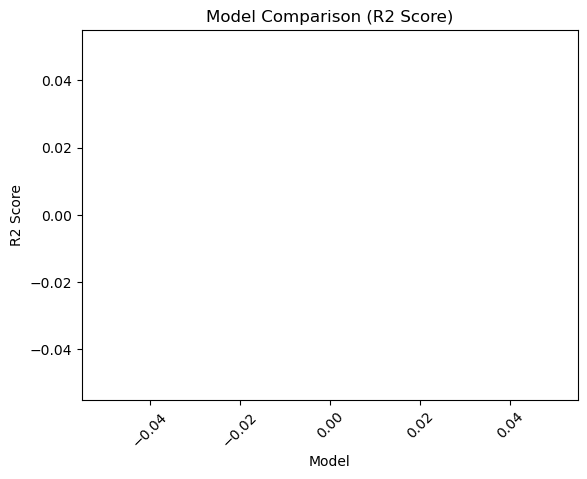

In [92]:
import matplotlib.pyplot as plt

# Plot R2 scores
model_names = list(results.keys())
r2_scores = [results[name]['R2'] for name in model_names]

plt.bar(model_names, r2_scores)
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Comparison (R2 Score)')
plt.xticks(rotation=45)
plt.show()